In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
pd.set_option('display.min_rows', 100)

In [2]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

# User Latent Features

In [3]:
user_factors = pd.read_csv('data/user_factors.csv')

In [4]:
user_factors.head()

,id,features
0,640,"[0.5853673219680786, 1.1955639123916626, 0.495..."
1,650,"[0.7357923984527588, 1.1214193105697632, 0.211..."
2,660,"[0.41824525594711304, 0.8636453151702881, 0.40..."
3,670,"[0.0, 0.23701752722263336, 0.10014515370130539..."
4,680,"[0.2757687568664551, 0.9952836632728577, 0.413..."


# Movie Latent Features

In [5]:
movie_factors = pd.read_csv('data/movie_factors.csv')

In [6]:
movie_factors['features'][0]

'[0.1470944583415985, 1.0527691841125488, 0.06695104390382767, 0.2533167600631714, 0.17517654597759247, 0.5150220990180969, 0.18830619752407074, 0.5612077713012695, 0.11690513044595718, 0.7164477705955505]'

# Requests Data

In [9]:
requests_df = pd.read_csv('data/requests.csv')

In [10]:
requests_df.head()

,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


# Training Data

In [11]:
training = pd.read_csv('data/training.csv')

In [12]:
training.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [13]:
training['movie'].nunique()

3662

In [14]:
print('Training data statistics: ')
training.describe()

Training data statistics: 


,user,movie,rating,timestamp
count,800000.000000,800000.000000,800000.000000,8.000000e+05
mean,3403.097837,1849.257256,3.590479,9.683921e+08
std,1546.589028,1086.852485,1.120376,5.820931e+06
min,636.000000,1.000000,1.000000,9.567039e+08
25%,2035.000000,1028.000000,3.000000,9.641524e+08
50%,3507.000000,1788.000000,4.000000,9.675878e+08
75%,4695.000000,2750.000000,4.000000,9.746878e+08
max,6040.000000,3952.000000,5.000000,9.757673e+08


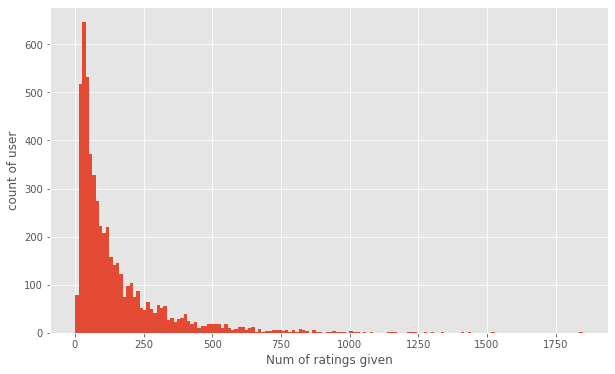

In [50]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(training.groupby('user').count()['rating'], bins=150)
ax.set_xlabel('Num of ratings given')
ax.set_ylabel('count of user');

# Movie Descriptions

In [64]:
movies = pd.read_csv('data/movies.dat', sep='::', engine='python', names=['movie_id', 'title', 'genre'])

In [65]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [62]:
movies['genre'].apply(lambda x: x.replace('|', ' '))

0          Animation Children's Comedy
1         Adventure Children's Fantasy
2                       Comedy Romance
3                         Comedy Drama
4                               Comedy
5                Action Crime Thriller
6                       Comedy Romance
7                 Adventure Children's
8                               Action
9            Action Adventure Thriller
10                Comedy Drama Romance
11                       Comedy Horror
12                Animation Children's
13                               Drama
14            Action Adventure Romance
15                      Drama Thriller
16                       Drama Romance
17                            Thriller
18                              Comedy
19                              Action
20                 Action Comedy Drama
21                Crime Drama Thriller
22                            Thriller
23                        Drama Sci-Fi
24                       Drama Romance
25                       

In [71]:
movies.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


# User Demographics

In [66]:
users_demo = pd.read_csv('data/users.dat', sep='::', engine='python', names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])

In [68]:
users_demo.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [69]:
users_demo.describe()

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [70]:
users_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipcode     6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


# Spark

In [ ]:
# Setup a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert a Pandas DF to a Spark DF
spark_df = spark.createDataFrame(training) 

spark_df = spark_df.drop('timestamp')

spark_df.printSchema()

In [ ]:
train, validation = spark_df.randomSplit([0.8, 0.2], seed=111)

In [ ]:
num_users = train.select('user').distinct().count()
num_movies = train.select('movie').distinct().count()
density = train.count() / (num_users*num_movies)
density

In [ ]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
)

recommender = als_model.fit(train)

predictions = recommender.transform(train)

predictions.describe().show()

In [ ]:
# recommender.itemFactors.show()

In [ ]:
# recommender.userFactors.show()

In [ ]:
# user1 = recommender.recommendForUserSubset(predictions, 10).where('user==700').select('recommendations').take(1)

# user1

In [ ]:
def predicted_rating(user_id, movie_id):
    try:
        user = recommender.userFactors.where(f'id == {user_id}').collect()[0]['features']
        item = recommender.itemFactors.where(f'id == {movie_id}').collect()[0]['features']
    except:
        user = 1
        item = -1
        
    return np.dot(np.array(user), np.array(item))

In [ ]:
predicted_rating(4615, 34)